In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL

from mac0460_5832.utils import *

######################################################################
#
# OBS:
#
# A função draw_img original lia o atributo shape como uma tupla
# (width, height). Como é mais natural descrever o shape de uma matriz
# como (linhas = height, colunas = width), eu optei por modificar essa
# função para ler os vetores dessa maneira. Os resultados não devem se
# alterar, apenas virar.


######################################################################
#
# Classes                                                       
#
###
# WOperator Learner Class
class WOperatorLearner:
    """ Class used to learn a biniary image operator """
    
    def __init__ (self, n, m):
        """ Class constructor """
        self.window_shape = (n, m)
        self.samples = {}
        self._update_hypothesis ()

        
    def sample_image (self, src, dest):
        """ Samples an image, adding samples to the self.samples
        hash """
        x_offset = int ((self.window_shape[1] - 1) / 2)
        y_offset = int ((self.window_shape[0] - 1) / 2)
        bsrc = zero_border_img (src, x_offset, y_offset)
        window_configuration = []
        sy, ey = 0, 2 * y_offset + 1
        for i in range (y_offset, y_offset + src.shape[0]):
            sx, ex = 0, 2 * x_offset + 1
            for j in range (x_offset, x_offset + src.shape[1]):
                w = bsrc[sy:ey, sx:ex]
                window = window_to_int (w, 2)
                label = dest[i - y_offset][j - x_offset]
                if (window not in self.samples):
                    self.samples[window] = [0, 0]
                self.samples[window][label] += 1
                sx += 1
                ex += 1
            sy += 1
            ey += 1
        self._update_hypothesis ()


    def get_hypothesis (self):
        return self.hypothesis


    def get_samples (self):
        return self.samples


    def _update_hypothesis (self):
        self.hypothesis = []
        h = self.hypothesis
        n = self.window_shape[0]
        m = self.window_shape[1]
        for x in range (2 ** (n * m)):
            h.append (False)
        for w in self.samples:
            l = self.samples[w][0] < self.samples[w][1]
            h[w] = l
    
    def clean_samples (self):
        self.samples = {}
        self._update_hypothesis ()
                
# End of WOperatorLearner Class
##           




###
# WOperator Classs
class WOperator:
    """ Class used to define a W-Operator """
    
    def __init__ (self, f):
        """ Class constructor. f should be an array of size
        2 ^ (window size) """
        self.f = f
        

    def operate_image (self, img):
        """ Operates over an image """

# End of WOperator Class
##



######################################################################
#
# General Use Functions                                                   
#
###
def window_to_int (window, base):
    """ Maps a window to an integer. The way this function works is
    reading the window as a number of base <base> from left to right
    and up to down. It returns the same number in base 10 """
    total = 0
    power = 1
    w = window.tolist ()
    for row in w:
        for element in row:
            total += element * power
            power *= base
    return int (total)


def int_to_window (number, base, shape):
    """ The inverse of window_to_int """
    power = 1
    window_size = shape[0] * shape[1]
    w_arr = []
    while (number > 0):
        d = number % base
        number = number // base
        w_arr.append (d)
    while (len (w_arr) < window_size):
        w_arr.append (0)
    w = np.array ([w_arr])
    w.reshape (shape)
    return w


def zero_border_img (img, x_border, y_border):
    """ This function creates a border of zeros on img """
    h = img.shape[0]
    w = img.shape[1]
    new_h = h + 2 * y_border
    new_w = w + 2 * x_border
    zeros = np.zeros ((new_h, new_w))
    bordered_img = zeros
    y_start, y_end = y_border, -y_border
    x_start, x_end = x_border, -x_border
    if y_border is 0: y_end = h
    if x_border is 0: x_end = w
    bordered_img[y_start:y_end, x_start:x_end] += img
    return bordered_img

# MAC0460/5832 - Lista 1: Aprendizado de W-Operadores

### Data de Entrega: 23h55m do dia 05/05/2017


Q1. Encontre, utilizando a técnica de aprendizado de w-operadores vista em sala, o operador 1x3 (1 linha, 3 colunas) capaz de transformar a imagem src1 em dest1 (veja as variáveis abaixo) mostrando a tabela de padrões encontrada. Teste seu operador na imagem src1 e verifique que ele funciona como esperado. Teste seu operador nas imagens images/q1/1_test1.png e images/q1/1_test2.png desenhando as imagens obtidas (sugestão: use a função draw_img do arquivo mac0460_5832/utils.py).

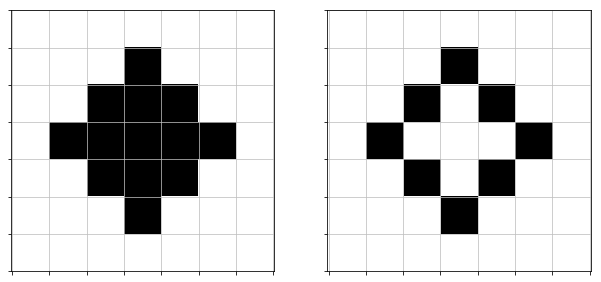

---------- Tabela de padrões encontrada: ---------
[[0, 0, 0]] zeros = 26, uns = 0
[[0, 0, 1]] zeros = 5, uns = 0
[[0, 1, 0]] zeros = 0, uns = 2
[[1, 0, 0]] zeros = 5, uns = 0
[[0, 1, 1]] zeros = 0, uns = 3
[[1, 1, 1]] zeros = 5, uns = 0
[[1, 1, 0]] zeros = 0, uns = 3


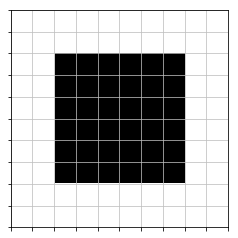

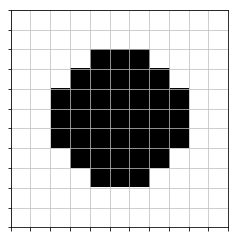

In [4]:
src1 = read_img('images/q1/1_src.png')
dest1 = read_img('images/q1/1_dest.png')
draw_img_pair(src1, dest1)

# creates w-operator and samples image
wopl = WOperatorLearner (1, 3)
w_shape = (1, 3)
wopl.sample_image (src1, dest1)
print ('---------- Tabela de padrões encontrada: ---------')
table = wopl.get_samples ()
for key in table:
    w = int_to_window (key, 2, w_shape)
    print (w.tolist (), end=' ')
    print ('zeros = ' + str (table[key][0]) + ', uns = ' + str (table[key][1]))
h = wopl.get_hypothesis ()



test1_1 = read_img('images/q1/1_test1.png')
test1_2 = read_img('images/q1/1_test2.png')
draw_img(test1_1)
draw_img(test1_2)

Q2. Aprenda o operador 3x3 para detecção de bordas. Treine seu operador nas imagens da pastas images/q2/ usando os pares (q2_src\*.png, q2_dest\*.png). Teste seu operador nas imagens images/q2/q2_test.png e images/q2/q2_test2.png. Algumas das imagens de treino são desenhadas abaixo.

In [ ]:
src2_1 = read_img('images/q2/q2_src1.png')
src2_2 = read_img('images/q2/q2_src2.png')
src2_3 = read_img('images/q2/q2_src3.png')

dest2_1 = read_img('images/q2/q2_dest1.png')
dest2_2 = read_img('images/q2/q2_dest2.png')
dest2_3 = read_img('images/q2/q2_dest3.png')


draw_img_pair(src2_1, dest2_1)
draw_img_pair(src2_2, dest2_2)
draw_img_pair(src2_3, dest2_3)

Q3. Use o algoritmo de aprendizado para obter um operador capaz de eliminar ruído. Use no treinamento as imagens images/q3/q3_src\*.png sempre com o mesmo target images/q3/q3_dest.png. Teste a janela com 5 elementos (cruz). Teste seu operador nas imagens images/q3/q3_test1.png e images/q3/q3_test2.png. Calcule e plote os erros $E_{in}$ e $E_{out}$ obtidos durante o treinamento.

In [ ]:
src3_1 = read_img('images/q3/q3_src1.png')
src3_2 = read_img('images/q3/q3_src2.png')
src3_3 = read_img('images/q3/q3_src3.png')
src3_4 = read_img('images/q3/q3_src4.png')
dest3 = read_img('images/q3/q3_dest.png')

draw_img(dest3)

draw_img_pair(src3_1, dest3)
draw_img_pair(src3_2, dest3)
draw_img_pair(src3_3, dest3)

Q4. Projete um operador para aprender a extrair a letra 's' de imagens de texto. Para isso utilize os pares de imagens q4_src\*.png q4_dest\*.png da pasta images/q4/train. Teste seu operador nas imagens da pasta images/q4/test. Utilize a composição de janelas pequenas. Avalie o erro do seu operador comparando a saída obtida por ele com a saída esperada (imagens q4_gt\*.png da pasta images/q4/test).

In [ ]:
dest4_1a = read_img("images/q4/train/q4_dest1a.png")
src4_1a = read_img("images/q4/train/q4_src1a.png")
dest4_1b = read_img("images/q4/train/q4_dest1b.png")
src4_1b = read_img("images/q4/train/q4_src1b.png")
draw_img_pair(src4_1a, dest4_1a, figsz=(15, 6))
draw_img_pair(src4_1b, dest4_1b, figsz=(15, 6))

Q5. Utilizando a técnica de multiresolução, aprenda o operador capaz de remover ruído das imagens da pasta images/q5/. Utilize os pares de imagens (q5_src\*.png, q5_dest.png) para o treinamento e depois teste seu  operador nas imagens q5_test1.png e q5_test2.png.

In [ ]:
dest5 = read_img("images/q5/q5_dest.png")
src5_1 = read_img("images/q5/q5_src1.png")
src5_2 = read_img("images/q5/q5_src2.png")
draw_img(dest5)
draw_img(src5_1)
draw_img(src5_2)

Q6. Utilize a técnica de envelope, como visto em sala, para remover ruído de imagens. Use o mesmo dataset da questão anterior e as funções de morfologia disponíveis em mac0460_5832/utils.py para definir as funções $\alpha$ e $\beta$. Um exemplo de erosão em uma das imagens de treino é mostrado abaixo. Comente sobre a escolha das funções $\alpha$ e $\beta$.

In [ ]:
src6_1 = read_img("images/q5/q5_src1.png")
draw_img(erosion(src6_1, se_box(2)))

Q7. Utilize a técnica de envelope com multiresolução para aprender um operador capaz de remover ruído de imagens. Para cada uma das janelas, defina funções $\alpha$ e $\beta$ (podem ser diferentes). Compare o resultado obtido aplicando a mistura de técnicas com os resultados das duas questões anteriores.

Q8. A função gen_rand_imgs abaixo retorna um par de imagens. A primeira contém alguns pontos gerados aleatoriamente. A segunda é a dilatação da primeira por um elemento estruturante em forma de cruz. Aprenda o operador capaz de realizar essa transformação, gerando os pares de src e dest. Crie os dados de treinamento baseado na equação vista em sala ($m(\epsilon, \delta, H) = \frac{1}{\epsilon}ln\frac{|H|}{\delta}$). Compare o resultado obtido pelo seu classificador (gere mais pares para teste e ter uma estimativa de $E_{out}$) para $\epsilon = [0.2, 0.1]$ e $\delta = [0.3, 0.2]$.

In [ ]:
def gen_rand_imgs():
    noise = np.zeros((20, 20)).astype(bool)
    num_pixels = 20
    x = np.random.randint(0, 20, num_pixels)
    y = np.random.randint(0, 20, num_pixels)

    for i in range(num_pixels):
        noise[x[i], y[i]] = 1

    return noise, dilation(noise, se_cross(1))

src5_1, dest5_1 = gen_rand_imgs()
src5_2, dest5_2 = gen_rand_imgs()
draw_img_pair(src5_1, dest5_1)
draw_img_pair(src5_2, dest5_2)